In [1]:
from __future__ import division
import os
import time
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.generic_utils import get_custom_objects

import pandas as pd

from ops import *
from utils import *


Using TensorFlow backend.


In [2]:
class MNIST_PINE(object):
    model_name = "MNIST_PINE"     # name for checkpoint

    def __init__(self, sess, epoch, batch_size, dataset_name, checkpoint_dir):
        self.sess = sess
        self.dataset_name = dataset_name
        self.checkpoint_dir = checkpoint_dir
        self.epoch = epoch
        self.batch_size = batch_size

        if dataset_name == 'mnist':
            # parameters
            self.input_height = 28
            self.input_width = 28
            self.output_height = 28
            self.output_width = 28
      
            self.y_dim = 10        
            self.c_dim = 1

            # train
            self.learning_rate = 0.0001
            self.beta1 = 0.5

            # test
            self.sample_num = 64  
            self.len_discrete_code = 10

            # load mnist
            self.data_X, self.data_y = load_mnist(self.dataset_name)

            # get number of batches for a single epoch
            self.num_batches = len(self.data_X) // self.batch_size
            self.kcc = tf.keras.losses.CategoricalCrossentropy()
        else:
            raise NotImplementedError
            

    def interpreter(self, x, is_training=True, reuse=False):
        
        with tf.compat.v1.variable_scope("interpreter", reuse=reuse):

            net = tf.nn.relu(coinv2d(x, 64, 4, 4, 2, 2, name='int_conv1'))
            net = tf.reshape(net, [self.batch_size, -1])
            code = (linear(net, 32, scope='int_fc6')) # bn and relu are excluded since code is used in pullaway_loss
            net = tf.nn.relu(bn(linear(code, 64 * 14 * 14, scope='int_fc3'), is_training=is_training, scope='int_bn3'))
            net = tf.reshape(net, [self.batch_size, 14, 14, 64])
            out = tf.nn.sigmoid(deconv2d(net, [self.batch_size, 28, 28, 1], 4, 4, 2, 2, name='int_dc5'))

            # recon loss
            recon_error = tf.sqrt(2 * tf.nn.l2_loss(out - x)) / self.batch_size
            return out, recon_error, code

    def main_model(self, x, is_training=True, reuse=False):

        with tf.compat.v1.variable_scope("main_model", reuse=reuse):    

            net = lrelu(coinv2d(x, 64, 4, 4, 2, 2, name='mm_conv1'))
            net = lrelu(bn(coinv2d(net, 128, 4, 4, 2, 2, name='mm_conv2'), is_training=is_training, scope='mm_bn2'))
            net = tf.reshape(net, [self.batch_size, -1])
            net = lrelu(bn(linear(net, 1024, scope='mm_fc3'), is_training=is_training, scope='mm_bn3'))
            out_logit = linear(net, 10, scope='mm_fc4')
            out = tf.nn.softmax(out_logit)

            return out, out_logit
        
    def build_pine(self):
        # some parameters
        image_dims = [self.input_height, self.input_width, self.c_dim]
        bs = self.batch_size

        """ Graph Input """
        # images
        self.inputs = tf.compat.v1.placeholder(tf.float32, [bs] + image_dims, name='real_images')

        # labels
        self.y = tf.compat.v1.placeholder(tf.float32, [bs, self.y_dim], name='y')


        """ Loss Function """


        tafsir, tafsir_err, code = self.interpreter(self.inputs, is_training=True)
        out_tafsir, out_logit_tafsir = self.main_model(tafsir, is_training=True)
        out_real, out_logit_real = self.main_model(self.inputs, is_training=True, reuse= True)        



        self.mm_loss = self.kcc(out_real,self.y)
        out_sqrt = tf.keras.backend.sqrt(out_tafsir)
        sumi = tf.keras.backend.sum(out_sqrt)**2
        self.int_loss = tafsir_err + self.kcc(out_tafsir, self.y) +0.0002*(sumi)


        """ Training """

        t_vars = tf.compat.v1.trainable_variables()
        int_vars = [var for var in t_vars if 'int_' in var.name]
        mm_vars = [var for var in t_vars if 'mm_' in var.name]

        # optimizers
        with tf.control_dependencies(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)):

            self.int_optim = tf.compat.v1.train.AdamOptimizer(self.learning_rate * 5, beta1=self.beta1) \
            .minimize(self.int_loss, var_list=int_vars)
            self.mm_optim = tf.compat.v1.train.AdamOptimizer(self.learning_rate * 5, beta1=self.beta1) \
            .minimize(self.mm_loss, var_list=mm_vars)


        """" Testing """
        # for test
        self.tafsir_images = self.interpreter(self.inputs, is_training=False, reuse=True)
        """ Summary """
        int_loss_sum = tf.compat.v1.summary.scalar("int_loss", self.int_loss)
        mm_loss_sum = tf.compat.v1.summary.scalar("mm_loss", self.mm_loss)

        self.int_sum = tf.compat.v1.summary.merge([int_loss_sum])
        self.mm_sum = tf.compat.v1.summary.merge([mm_loss_sum])       
    def train(self):

        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.test_codes = self.data_y[0:self.batch_size]
        self.sample_input = self.data_X[0:self.batch_size]

        # saver to save model
        self.saver = tf.compat.v1.train.Saver()

        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [i] OK. I've found it.")
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [i] NOTHING FOUND TO LOAD!")

        # loop for epoch
        start_time = time.time()
        for epoch in range(start_epoch, self.epoch):

            # get batch data
            for idx in range(start_batch_id, self.num_batches):
                batch_images = self.data_X[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_codes = self.data_y[idx * self.batch_size:(idx + 1) * self.batch_size]


                #update Interpreter
                _, summary_str, int_loss = self.sess.run([self.int_optim, self.int_sum, self.int_loss],
                                                       feed_dict={self.inputs: batch_images, self.y: batch_codes})

                # update Main Model
                _, summary_str_mm, mm_loss = self.sess.run(
                    [self.mm_optim, self.mm_sum, self.mm_loss],
                    feed_dict={self.y: batch_codes, self.inputs: batch_images})


                # display training status
                counter += 1
                print("Epoch: [%2d] [%4d/%4d] time: %4.4f, int_loss: %.8f,mm_loss: %.8f" \
                      % (epoch, idx, self.num_batches, time.time() - start_time, int_loss, mm_loss))


            start_batch_id = 0

            # save model
            self.save(self.checkpoint_dir, counter)

        # save model for final step
        self.save(self.checkpoint_dir, counter)

    @property
    def model_dir(self):
        return "{}_{}".format(
            self.model_name, self.dataset_name)

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,os.path.join(checkpoint_dir, self.model_name+'.model'), global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [i] Wait a sec...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
            print(" [i] OK. Reading Completed! {}".format(ckpt_name))
            return True, counter
        else:
            print(" [i] NO CHECKPOINTS FOUND!")
            return False, 0
    def just_load(self, tobe_tafsired):
        
        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.test_codes = self.data_y[0:self.batch_size]
        self.sample_input = self.data_X[0:self.batch_size]


        # saver to save model
        self.saver = tf.compat.v1.train.Saver()


        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [i] Loading done!")
        samples, recon_error, code = self.sess.run(self.tafsir_images, feed_dict={self.inputs: tobe_tafsired})
        return samples
    

In [3]:
samples = []
X_test = pd.read_csv("test.csv")
X_test = X_test/255
X_test = X_test.values.reshape(-1,28,28,1)
tobe_tafsired = X_test[0:64]
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as sess:
# open session
    pine = MNIST_PINE(sess,
                epoch=5,
                batch_size=64,
                dataset_name='mnist',
                checkpoint_dir= 'checkpoint')

    # build graph
    pine.build_pine()
    # initialize all variables
    pine.train()
    samples = pine.just_load(tobe_tafsired)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


 [i] Wait a sec...
INFO:tensorflow:Restoring parameters from checkpoint/MNIST_PINE_mnist/MNIST_PINE/MNIST_PINE.model-4372


INFO:tensorflow:Restoring parameters from checkpoint/MNIST_PINE_mnist/MNIST_PINE/MNIST_PINE.model-4372


 [i] OK. Reading Completed! MNIST_PINE.model-4372
 [i] OK. I've found it.
Epoch: [ 4] [   0/1093] time: 0.3751, int_loss: 2.33950162,mm_loss: 0.11737739
Epoch: [ 4] [   1/1093] time: 0.4743, int_loss: 2.13638902,mm_loss: 0.05013314
Epoch: [ 4] [   2/1093] time: 0.5752, int_loss: 1.90607929,mm_loss: 0.25203016
Epoch: [ 4] [   3/1093] time: 0.6888, int_loss: 2.14450502,mm_loss: 0.01198743
Epoch: [ 4] [   4/1093] time: 0.7888, int_loss: 2.10237646,mm_loss: 0.01944918
Epoch: [ 4] [   5/1093] time: 0.8890, int_loss: 2.11709380,mm_loss: 0.00929743
Epoch: [ 4] [   6/1093] time: 1.0009, int_loss: 2.11374474,mm_loss: 0.45237407
Epoch: [ 4] [   7/1093] time: 1.1015, int_loss: 1.87467599,mm_loss: 0.45463490
Epoch: [ 4] [   8/1093] time: 1.2012, int_loss: 1.64379644,mm_loss: 0.00690318
Epoch: [ 4] [   9/1093] time: 1.3118, int_loss: 1.91190696,mm_loss: 0.05533952
Epoch: [ 4] [  10/1093] time: 1.4137, int_loss: 2.13547277,mm_loss: 0.48178929
Epoch: [ 4] [  11/1093] time: 1.5127, int_loss: 2.0777521

Epoch: [ 4] [ 103/1093] time: 11.6632, int_loss: 2.54458523,mm_loss: 0.48616129
Epoch: [ 4] [ 104/1093] time: 11.7973, int_loss: 2.33920574,mm_loss: 0.20947972
Epoch: [ 4] [ 105/1093] time: 11.9372, int_loss: 1.69176412,mm_loss: 0.01417533
Epoch: [ 4] [ 106/1093] time: 12.0684, int_loss: 1.63533890,mm_loss: 0.00300745
Epoch: [ 4] [ 107/1093] time: 12.1969, int_loss: 2.04168344,mm_loss: 0.03405888
Epoch: [ 4] [ 108/1093] time: 12.3272, int_loss: 1.70946527,mm_loss: 0.01286341
Epoch: [ 4] [ 109/1093] time: 12.4536, int_loss: 2.33767056,mm_loss: 0.01995853
Epoch: [ 4] [ 110/1093] time: 12.5746, int_loss: 1.63102627,mm_loss: 0.18457669
Epoch: [ 4] [ 111/1093] time: 12.6887, int_loss: 1.69722652,mm_loss: 0.21338058
Epoch: [ 4] [ 112/1093] time: 12.8088, int_loss: 1.65432739,mm_loss: 0.00765270
Epoch: [ 4] [ 113/1093] time: 12.9116, int_loss: 1.80060458,mm_loss: 0.00185462
Epoch: [ 4] [ 114/1093] time: 13.0233, int_loss: 1.84903073,mm_loss: 0.00062588
Epoch: [ 4] [ 115/1093] time: 13.1274, i

Epoch: [ 4] [ 207/1093] time: 22.8416, int_loss: 2.86822248,mm_loss: 0.97603762
Epoch: [ 4] [ 208/1093] time: 22.9447, int_loss: 1.89579976,mm_loss: 0.24188997
Epoch: [ 4] [ 209/1093] time: 23.0455, int_loss: 1.86388373,mm_loss: 0.19335599
Epoch: [ 4] [ 210/1093] time: 23.1527, int_loss: 1.72333455,mm_loss: 0.47616628
Epoch: [ 4] [ 211/1093] time: 23.2543, int_loss: 1.58817589,mm_loss: 0.00229001
Epoch: [ 4] [ 212/1093] time: 23.3572, int_loss: 2.38255143,mm_loss: 0.11696261
Epoch: [ 4] [ 213/1093] time: 23.4568, int_loss: 1.62517309,mm_loss: 0.00063551
Epoch: [ 4] [ 214/1093] time: 23.5607, int_loss: 1.63391495,mm_loss: 0.00677943
Epoch: [ 4] [ 215/1093] time: 23.6615, int_loss: 1.65597689,mm_loss: 0.02479383
Epoch: [ 4] [ 216/1093] time: 23.7633, int_loss: 2.22733808,mm_loss: 0.51127481
Epoch: [ 4] [ 217/1093] time: 23.8631, int_loss: 1.85818326,mm_loss: 0.00640256
Epoch: [ 4] [ 218/1093] time: 23.9664, int_loss: 2.13969231,mm_loss: 0.55354208
Epoch: [ 4] [ 219/1093] time: 24.0662, i

Epoch: [ 4] [ 311/1093] time: 33.9904, int_loss: 2.04063988,mm_loss: 0.34638757
Epoch: [ 4] [ 312/1093] time: 34.0954, int_loss: 1.84846306,mm_loss: 0.00560844
Epoch: [ 4] [ 313/1093] time: 34.1970, int_loss: 3.24011111,mm_loss: 0.21330173
Epoch: [ 4] [ 314/1093] time: 34.3177, int_loss: 1.86142731,mm_loss: 0.12822060
Epoch: [ 4] [ 315/1093] time: 34.4302, int_loss: 2.13718653,mm_loss: 0.04094352
Epoch: [ 4] [ 316/1093] time: 34.5340, int_loss: 1.95178485,mm_loss: 0.11339696
Epoch: [ 4] [ 317/1093] time: 34.6364, int_loss: 1.61287093,mm_loss: 0.00331561
Epoch: [ 4] [ 318/1093] time: 34.7492, int_loss: 2.47051692,mm_loss: 0.42552608
Epoch: [ 4] [ 319/1093] time: 34.8597, int_loss: 2.02489424,mm_loss: 0.01009682
Epoch: [ 4] [ 320/1093] time: 34.9640, int_loss: 1.90221262,mm_loss: 0.01621833
Epoch: [ 4] [ 321/1093] time: 35.0664, int_loss: 1.89598167,mm_loss: 0.02754287
Epoch: [ 4] [ 322/1093] time: 35.1813, int_loss: 2.09810686,mm_loss: 0.58421236
Epoch: [ 4] [ 323/1093] time: 35.2894, i

Epoch: [ 4] [ 416/1093] time: 45.2030, int_loss: 1.92062616,mm_loss: 0.31734878
Epoch: [ 4] [ 417/1093] time: 45.3035, int_loss: 1.87804139,mm_loss: 0.02293039
Epoch: [ 4] [ 418/1093] time: 45.4159, int_loss: 1.73002958,mm_loss: 0.23096244
Epoch: [ 4] [ 419/1093] time: 45.5330, int_loss: 2.39114165,mm_loss: 0.39146912
Epoch: [ 4] [ 420/1093] time: 45.6444, int_loss: 2.11588454,mm_loss: 0.25770867
Epoch: [ 4] [ 421/1093] time: 45.7481, int_loss: 1.73954034,mm_loss: 0.43049917
Epoch: [ 4] [ 422/1093] time: 45.8484, int_loss: 1.89832556,mm_loss: 0.29593849
Epoch: [ 4] [ 423/1093] time: 45.9519, int_loss: 1.88816178,mm_loss: 0.28095815
Epoch: [ 4] [ 424/1093] time: 46.0516, int_loss: 2.49800324,mm_loss: 0.26602232
Epoch: [ 4] [ 425/1093] time: 46.1643, int_loss: 2.14510775,mm_loss: 0.31041718
Epoch: [ 4] [ 426/1093] time: 46.2769, int_loss: 2.15767717,mm_loss: 0.25222239
Epoch: [ 4] [ 427/1093] time: 46.3776, int_loss: 2.13972998,mm_loss: 0.00029114
Epoch: [ 4] [ 428/1093] time: 46.4778, i

Epoch: [ 4] [ 519/1093] time: 56.1056, int_loss: 2.33269072,mm_loss: 0.62172788
Epoch: [ 4] [ 520/1093] time: 56.2106, int_loss: 1.62322474,mm_loss: 0.15496543
Epoch: [ 4] [ 521/1093] time: 56.3115, int_loss: 1.75839555,mm_loss: 0.04211019
Epoch: [ 4] [ 522/1093] time: 56.4108, int_loss: 2.18035269,mm_loss: 0.26157257
Epoch: [ 4] [ 523/1093] time: 56.5093, int_loss: 1.60039628,mm_loss: 0.00845940
Epoch: [ 4] [ 524/1093] time: 56.6121, int_loss: 1.68410480,mm_loss: 0.12564120
Epoch: [ 4] [ 525/1093] time: 56.7133, int_loss: 1.88556635,mm_loss: 0.22665836
Epoch: [ 4] [ 526/1093] time: 56.8138, int_loss: 1.64208579,mm_loss: 0.00882493
Epoch: [ 4] [ 527/1093] time: 56.9148, int_loss: 1.83489537,mm_loss: 0.07564644
Epoch: [ 4] [ 528/1093] time: 57.0281, int_loss: 2.03307438,mm_loss: 0.25153404
Epoch: [ 4] [ 529/1093] time: 57.1328, int_loss: 2.11595726,mm_loss: 0.43586931
Epoch: [ 4] [ 530/1093] time: 57.2719, int_loss: 1.57048273,mm_loss: 0.02629600
Epoch: [ 4] [ 531/1093] time: 57.4029, i

Epoch: [ 4] [ 624/1093] time: 67.8554, int_loss: 1.62025428,mm_loss: 0.00639371
Epoch: [ 4] [ 625/1093] time: 67.9610, int_loss: 2.36967564,mm_loss: 0.48424235
Epoch: [ 4] [ 626/1093] time: 68.0663, int_loss: 2.10820222,mm_loss: 0.08828537
Epoch: [ 4] [ 627/1093] time: 68.1689, int_loss: 1.64643097,mm_loss: 0.01602606
Epoch: [ 4] [ 628/1093] time: 68.2711, int_loss: 1.93227232,mm_loss: 0.01496416
Epoch: [ 4] [ 629/1093] time: 68.3729, int_loss: 1.62826526,mm_loss: 0.00167712
Epoch: [ 4] [ 630/1093] time: 68.4744, int_loss: 1.86665583,mm_loss: 0.16113187
Epoch: [ 4] [ 631/1093] time: 68.5866, int_loss: 1.96363020,mm_loss: 0.08599207
Epoch: [ 4] [ 632/1093] time: 68.7470, int_loss: 1.58089805,mm_loss: 0.00684151
Epoch: [ 4] [ 633/1093] time: 68.8994, int_loss: 1.62385869,mm_loss: 0.00392672
Epoch: [ 4] [ 634/1093] time: 69.0019, int_loss: 1.83707905,mm_loss: 0.01256532
Epoch: [ 4] [ 635/1093] time: 69.1037, int_loss: 2.25996661,mm_loss: 0.00562777
Epoch: [ 4] [ 636/1093] time: 69.2068, i

Epoch: [ 4] [ 727/1093] time: 78.7388, int_loss: 1.66030216,mm_loss: 0.00047947
Epoch: [ 4] [ 728/1093] time: 78.8393, int_loss: 1.88033462,mm_loss: 0.02579277
Epoch: [ 4] [ 729/1093] time: 78.9413, int_loss: 2.76811218,mm_loss: 0.32932073
Epoch: [ 4] [ 730/1093] time: 79.0444, int_loss: 2.18082976,mm_loss: 0.27718681
Epoch: [ 4] [ 731/1093] time: 79.1456, int_loss: 2.14564848,mm_loss: 0.33089843
Epoch: [ 4] [ 732/1093] time: 79.2465, int_loss: 2.08190584,mm_loss: 0.29558071
Epoch: [ 4] [ 733/1093] time: 79.3512, int_loss: 2.35470176,mm_loss: 0.03875820
Epoch: [ 4] [ 734/1093] time: 79.4521, int_loss: 1.87963879,mm_loss: 0.05245766
Epoch: [ 4] [ 735/1093] time: 79.5525, int_loss: 1.63234663,mm_loss: 0.00605048
Epoch: [ 4] [ 736/1093] time: 79.6552, int_loss: 2.12319922,mm_loss: 0.24440816
Epoch: [ 4] [ 737/1093] time: 79.7554, int_loss: 2.90524435,mm_loss: 0.53887349
Epoch: [ 4] [ 738/1093] time: 79.8588, int_loss: 1.63974822,mm_loss: 0.00039459
Epoch: [ 4] [ 739/1093] time: 79.9619, i

Epoch: [ 4] [ 831/1093] time: 89.9610, int_loss: 1.59894824,mm_loss: 0.02682057
Epoch: [ 4] [ 832/1093] time: 90.1126, int_loss: 2.27695656,mm_loss: 0.35319573
Epoch: [ 4] [ 833/1093] time: 90.2255, int_loss: 1.58205199,mm_loss: 0.14120033
Epoch: [ 4] [ 834/1093] time: 90.3281, int_loss: 1.94727170,mm_loss: 0.00239787
Epoch: [ 4] [ 835/1093] time: 90.4310, int_loss: 1.66749418,mm_loss: 0.00030863
Epoch: [ 4] [ 836/1093] time: 90.5319, int_loss: 2.83930779,mm_loss: 0.61737972
Epoch: [ 4] [ 837/1093] time: 90.6320, int_loss: 1.82279706,mm_loss: 0.04999589
Epoch: [ 4] [ 838/1093] time: 90.7352, int_loss: 2.00702333,mm_loss: 0.13102746
Epoch: [ 4] [ 839/1093] time: 90.8373, int_loss: 1.79565203,mm_loss: 0.06974582
Epoch: [ 4] [ 840/1093] time: 90.9469, int_loss: 1.90768898,mm_loss: 0.25840959
Epoch: [ 4] [ 841/1093] time: 91.0600, int_loss: 2.28499794,mm_loss: 0.14244792
Epoch: [ 4] [ 842/1093] time: 91.1697, int_loss: 2.38371181,mm_loss: 0.10496007
Epoch: [ 4] [ 843/1093] time: 91.2781, i

Epoch: [ 4] [ 935/1093] time: 101.1468, int_loss: 2.38090944,mm_loss: 0.54734576
Epoch: [ 4] [ 936/1093] time: 101.2483, int_loss: 1.83240938,mm_loss: 0.26359141
Epoch: [ 4] [ 937/1093] time: 101.3488, int_loss: 2.13123107,mm_loss: 0.09049260
Epoch: [ 4] [ 938/1093] time: 101.4542, int_loss: 1.97096813,mm_loss: 0.00028745
Epoch: [ 4] [ 939/1093] time: 101.5575, int_loss: 1.93118799,mm_loss: 0.22447143
Epoch: [ 4] [ 940/1093] time: 101.6575, int_loss: 2.53193164,mm_loss: 0.58441472
Epoch: [ 4] [ 941/1093] time: 101.7587, int_loss: 1.84978902,mm_loss: 0.01419979
Epoch: [ 4] [ 942/1093] time: 101.8610, int_loss: 3.15586734,mm_loss: 0.69501853
Epoch: [ 4] [ 943/1093] time: 101.9645, int_loss: 1.83972263,mm_loss: 0.00051719
Epoch: [ 4] [ 944/1093] time: 102.0692, int_loss: 2.12673736,mm_loss: 0.01891164
Epoch: [ 4] [ 945/1093] time: 102.1716, int_loss: 1.86099744,mm_loss: 0.00258151
Epoch: [ 4] [ 946/1093] time: 102.2738, int_loss: 2.04151821,mm_loss: 0.01998996
Epoch: [ 4] [ 947/1093] time

Epoch: [ 4] [1037/1093] time: 111.8346, int_loss: 1.65029430,mm_loss: 0.17352749
Epoch: [ 4] [1038/1093] time: 111.9358, int_loss: 1.62144423,mm_loss: 0.01089973
Epoch: [ 4] [1039/1093] time: 112.0368, int_loss: 2.28728342,mm_loss: 0.00361675
Epoch: [ 4] [1040/1093] time: 112.1386, int_loss: 2.38178062,mm_loss: 0.49495092
Epoch: [ 4] [1041/1093] time: 112.2405, int_loss: 1.84917152,mm_loss: 0.00875014
Epoch: [ 4] [1042/1093] time: 112.3435, int_loss: 1.64143777,mm_loss: 0.02013817
Epoch: [ 4] [1043/1093] time: 112.4473, int_loss: 1.88686514,mm_loss: 0.40716419
Epoch: [ 4] [1044/1093] time: 112.5499, int_loss: 1.63526750,mm_loss: 0.17551847
Epoch: [ 4] [1045/1093] time: 112.6512, int_loss: 1.94787812,mm_loss: 0.25862128
Epoch: [ 4] [1046/1093] time: 112.7524, int_loss: 1.58447433,mm_loss: 0.00260292
Epoch: [ 4] [1047/1093] time: 112.8545, int_loss: 2.13189435,mm_loss: 0.46953937
Epoch: [ 4] [1048/1093] time: 112.9569, int_loss: 1.89344895,mm_loss: 0.02079458
Epoch: [ 4] [1049/1093] time

INFO:tensorflow:Restoring parameters from checkpoint/MNIST_PINE_mnist/MNIST_PINE/MNIST_PINE.model-5465


 [i] OK. Reading Completed! MNIST_PINE.model-5465
 [*] Load SUCCESS


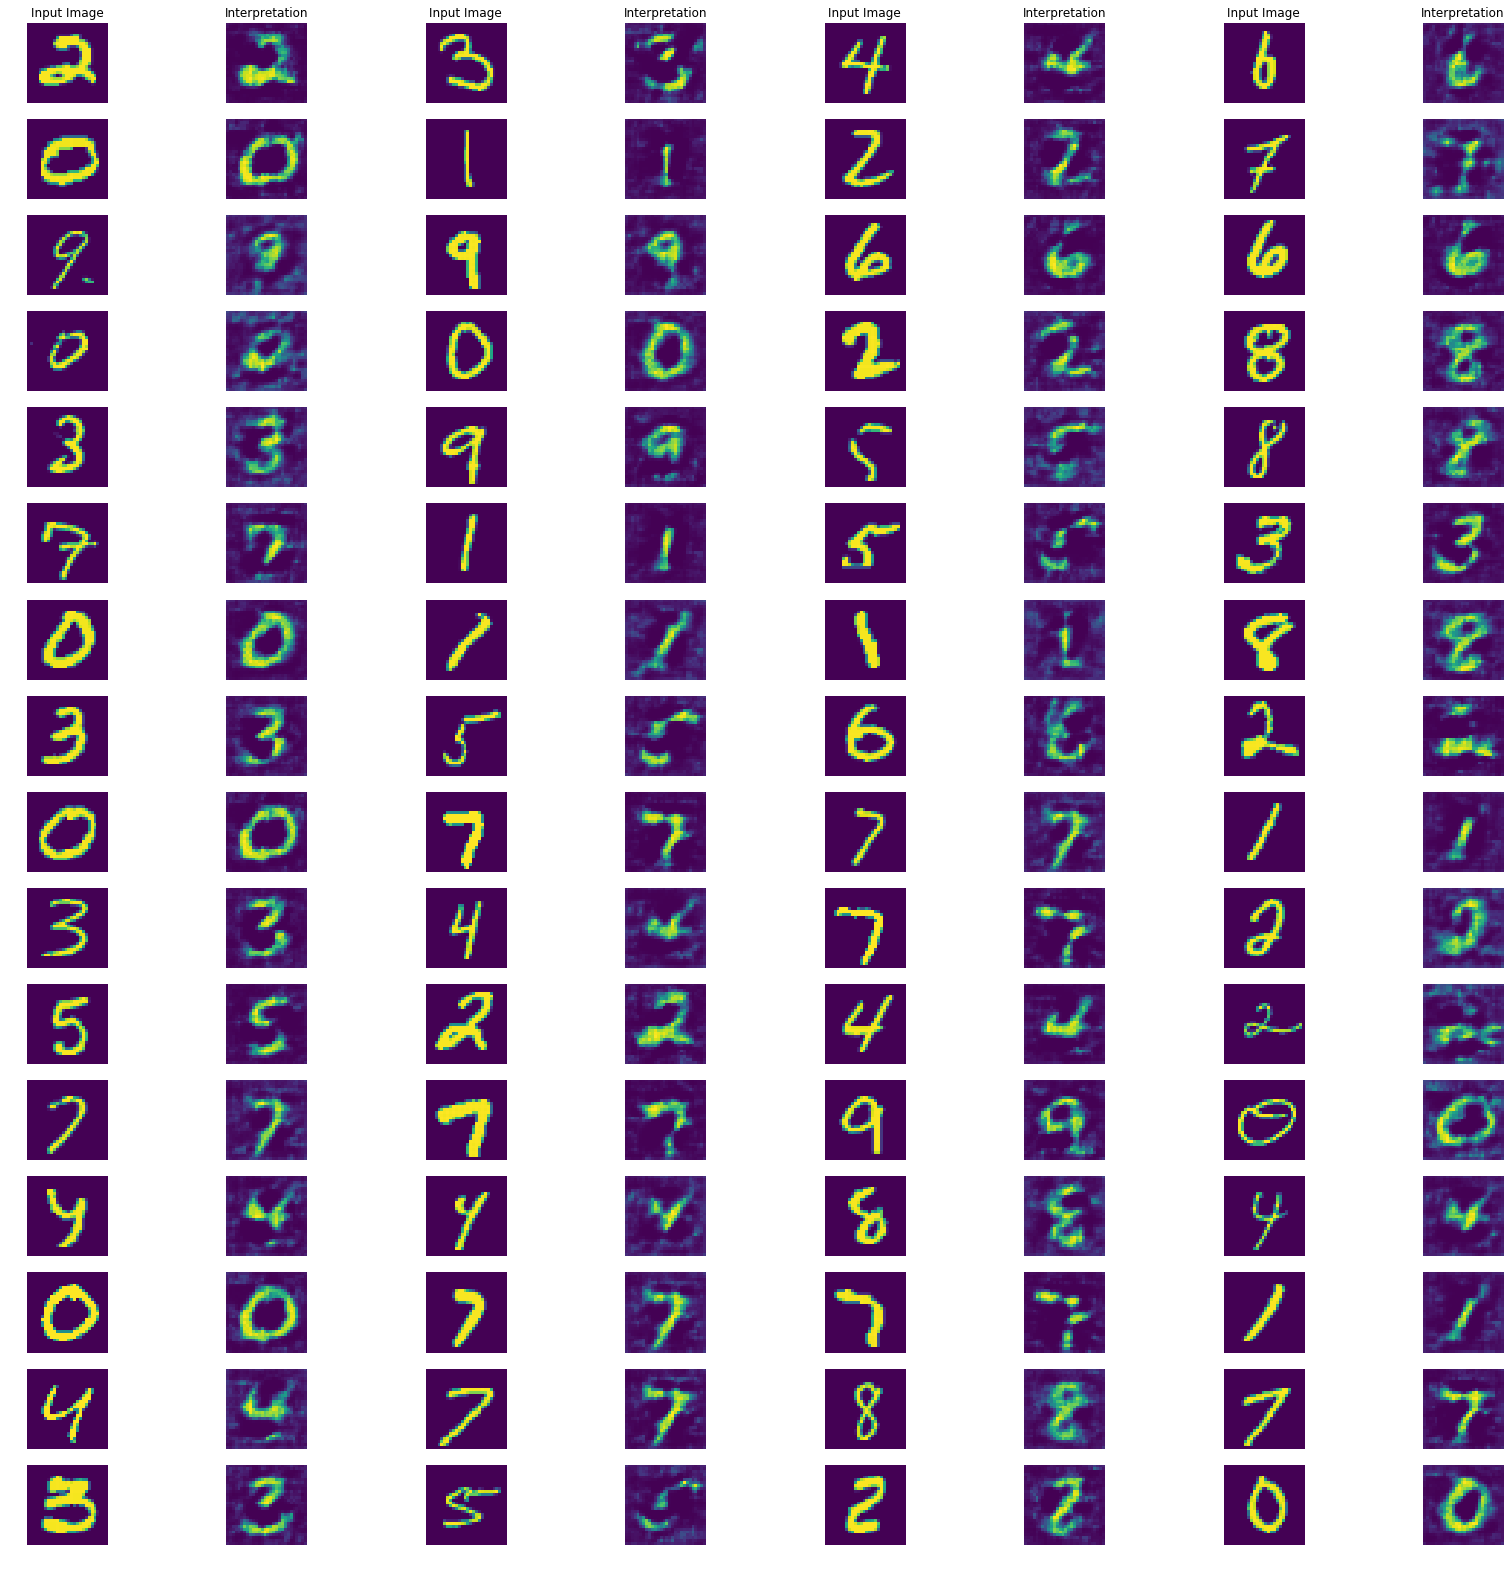

<Figure size 1440x1440 with 0 Axes>

In [163]:
import numpy as np
fig, axs = plt.subplots(16, 8, figsize=(28,28))
axs[0, 0].set_title('Input Image')
axs[0, 2].set_title('Input Image')
axs[0, 4].set_title('Input Image')
axs[0, 6].set_title('Input Image')
axs[0, 1].set_title('Interpretation')
axs[0, 3].set_title('Interpretation')
axs[0, 5].set_title('Interpretation')
axs[0, 7].set_title('Interpretation')

fig= plt.figure(figsize=(20, 20))

for j in range(0,4):
    for i in range(0,16):
        sam = tobe_tafsired[i+j*16].reshape((28,28))
        axs[i, 2*j].imshow(sam)
        axs[i, 2*j].axis('off')

        
for j in range(0,4):
    for i in range(0,16):
        aa = samples[i+j*16].reshape((28,28))
        axs[i, 2*j+1].imshow(aa)
        axs[i, 2*j+1].axis('off')        
plt.show()